In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from MakeData import make_data
import matplotlib.pyplot as plt
from datetime import datetime

In [6]:
class MyDataSet(Dataset):
    def __init__(self, features_path, labels_path, trans=None, target_trans=None):
        self.features = np.load(features_path, allow_pickle=True)
        self.labels = np.load(labels_path, allow_pickle=True)
        self.trans = trans
        self.target_trans = target_trans

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        feature, label = self.features[item], self.labels[item]
        if self.trans:
            feature = self.trans(feature)
        if self.target_trans:
            label = self.target_trans(label)
        return feature, label


def my_trans(x):
    return torch.Tensor(x)

train_set = MyDataSet('../../../Train/train_features.npy', '../../../Train/train_labels.npy',
                      trans=my_trans, target_trans=my_trans)
test_set = MyDataSet('../../../Train/test_features.npy', '../../../Train/test_labels.npy',
                      trans=my_trans, target_trans=my_trans)
train_loader = DataLoader(train_set, batch_size=10)
test_loader = DataLoader(test_set, batch_size=10)

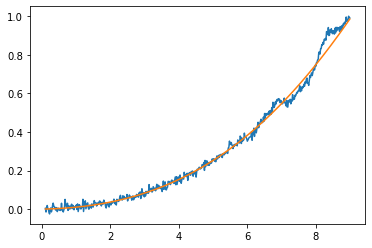

6 512


In [7]:
plt.figure()
feature, label = train_set[1]
x = np.linspace(0.1, 9, 512)
plt.plot(x, feature)
plt.plot(x, np.poly1d([*label, 0])(x/9))
plt.show()
print(len(label), len(feature))

In [8]:
class LK(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(512, 200)
        self.activation1 = torch.nn.Tanh()
        self.l2 = nn.Linear(200, 6)
        self.activation2 = torch.nn.Tanh()

    def forward(self, x):
        x = self.l1(x)
        x = self.activation1(x)
        x = self.l2(x)
        x = self.activation2(x)
        return x

my_model = LK()

print('parameters:')
for pa in my_model.parameters():
    print(pa)

parameters:
Parameter containing:
tensor([[ 0.0209, -0.0395,  0.0106,  ...,  0.0399, -0.0298, -0.0071],
        [ 0.0220,  0.0077, -0.0399,  ..., -0.0007,  0.0206,  0.0344],
        [ 0.0132,  0.0184, -0.0152,  ..., -0.0124, -0.0183,  0.0010],
        ...,
        [ 0.0032,  0.0381,  0.0436,  ..., -0.0148, -0.0243,  0.0188],
        [-0.0208, -0.0292,  0.0111,  ..., -0.0146, -0.0298,  0.0051],
        [ 0.0330,  0.0197, -0.0088,  ..., -0.0391,  0.0020,  0.0012]],
       requires_grad=True)
Parameter containing:
tensor([-0.0411, -0.0119, -0.0119,  0.0353, -0.0441,  0.0265,  0.0334,  0.0320,
        -0.0092,  0.0336,  0.0439, -0.0052,  0.0183,  0.0437,  0.0206, -0.0005,
        -0.0084,  0.0313, -0.0122,  0.0131,  0.0258,  0.0067, -0.0255,  0.0169,
        -0.0309, -0.0264, -0.0368, -0.0145, -0.0147, -0.0245,  0.0439,  0.0020,
         0.0023, -0.0414,  0.0203,  0.0163, -0.0188, -0.0175,  0.0130, -0.0013,
         0.0336,  0.0143, -0.0048,  0.0182,  0.0285,  0.0155,  0.0291,  0.0036,
   

In [9]:
loss_fn = torch.nn.MSELoss()
feature, label = train_set[1]
outputs = label + 2

print(f'train label:\n{label}\n')
print(f'loss:\n{loss_fn(outputs, label)}')
print(f'loss:\n{loss_fn(label, label)}')

train label:
tensor([-0.0686,  0.0655, -0.0009,  0.4491,  0.5124,  0.0279])

loss:
4.0
loss:
0.0


In [10]:
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.002, momentum=0.9)

In [11]:
def train_one_epoch(epoch_index, writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_loader):
        input, label = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        output = my_model(input)

        # Compute the loss and its gradients
        loss = loss_fn(output, label)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch

            loss_x = epoch_index * len(train_loader) + i + 1
            writer.add_scalar('Loss/train', last_loss, loss_x)

            running_loss = 0.

    return last_loss

In [12]:
from torch.utils.tensorboard import SummaryWriter
epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'../logs/{timestamp}')

epoch_number = 0
EPOCHS = 20

best_vloss = 1e-3

for epoch in range(EPOCHS):
    # Make sure gradient tracking is on, and do a pass over the data
    my_model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    my_model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        voutputs = my_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    if epoch_number % 5 == 4:
        print(f'EPOCH {epoch_number + 1}:')
        print(f'LOSS train {avg_loss: .4f} valid {avg_vloss: .4f}')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' :avg_loss, 'Validation': avg_vloss},
                    epoch_number + 1)
    writer.flush()

    epoch_number += 1
    if avg_loss < best_vloss:
        break

EPOCH 5:
LOSS train  0.3677 valid  0.2777
EPOCH 10:
LOSS train  0.3597 valid  0.2711
EPOCH 15:
LOSS train  0.3522 valid  0.2648
EPOCH 20:
LOSS train  0.3444 valid  0.2582


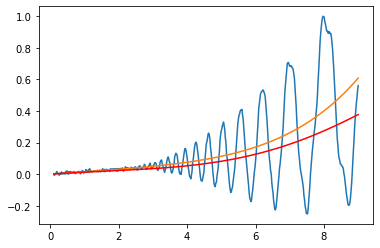

6 512


In [13]:
feature, a1, a2, label = make_data(x, f_num=2, poly_order=6,
         rdio=[1, 2],f_range=[[50, 60],[150, 250]],
         m_range=[0.4, 0.8], t_range=[1, 2], td_range=[2, 4])
feature, label = torch.Tensor(feature), torch.Tensor(label)
label_pre = my_model(feature)

plt.figure()
x = np.linspace(0.1, 9, 512)
plt.plot(x, feature)
plt.plot(x, np.poly1d([*label, 0])(x/9))
plt.plot(x, np.poly1d(np.append(label_pre.detach().numpy(), 0))(x/9), c='r')
plt.show()
print(len(label), len(feature))

In [14]:
len(feature)


512